# Progressive Inference for Music Demixing ID: L12
Description: Using denoising diffusion approaches to train music demixing (MDX) models is
promising but requires retraining large and carefully tuned neural networks (Plaja-Roglans,
2022). Instead, we will explore a related yet different approach: can we improve separation
quality solely by scheduling the inference process using a diffusion-inspired strategy even
without retraining? By experimenting with existing MDX models (Spleeter by Deezer,Meta’s Demucs, ByteDance’s BS-Roformer, etc.), this project offers an exciting opportunity
to explore and possibly enhance the performance of state-of-the-art AI techniques.

**Resources**


(Plaja-Roglans, 2022) https://ismir2022program.ismir.net/poster_262.html
Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2006.11239
MDX Challenge 2021: https://arxiv.org/abs/2108.13559
MDX Challenge 2023: https://arxiv.org/abs/2308.06979
Overview of state-of-the-art MDX models:
https://paperswithcode.com/sota/music-source-separation-on-musdb18-hq

### Preliminary step: Install and Import Libraries.

In [2]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [22]:
import IPython
import torch
import torchaudio
import os
import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio
from mir_eval import separation
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB_PLUS
from torchaudio.transforms import Fade


### Load the Model

In [20]:
bundle = HDEMUCS_HIGH_MUSDB_PLUS
model = bundle.get_model()
sample_rate = bundle.sample_rate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

HDemucs(
  (freq_encoder): ModuleList(
    (0): _HEncLayer(
      (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
      (norm1): Identity()
      (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      (norm2): Identity()
      (dconv): _DConv(
        (layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
            (4): GroupNorm(1, 96, eps=1e-05, affine=True)
            (5): GLU(dim=1)
            (6): _LayerScale()
          )
          (1): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
           

### Load the Dataset

Download the dataset at: https://zenodo.org/records/3338373

In [ ]:
# Load dataset and choose the length of the tracks for each song (in seconds)
DATASET_FOLDER =  "./musdb18hq/test"
SEGMENT = 30  # We'll keep exactly 30 seconds from each track


track_folders = sorted(
    folder for folder in os.listdir(DATASET_FOLDER)
    if os.path.isdir(os.path.join(DATASET_FOLDER, folder))
)

# Dictionary to store {track_folder -> {stem_name -> waveform}}
dataset_dict = {}


# Each subfolder in musdb18hq/test corresponds to a track
for track_folder in track_folders:
    track_path = os.path.join(DATASET_FOLDER, track_folder)
    if not os.path.isdir(track_path):
        continue

    # Prepare a sub-dictionary for this track
    stems_dict = {}
    stem_names = ["mixture", "drums", "bass", "vocals", "other"]
    
    for stem_name in stem_names:
        file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
        
        if not os.path.isfile(file_path):
            print(f"Warning: file not found {file_path}")
            continue

        # Load full audio
        print(f"Loading {file_path}...")
        waveform, sr = torchaudio.load(file_path)
        
        # Keep only the first 30s
        segment_samples = SEGMENT * sr
        waveform_segment = waveform[:, :segment_samples]

        stems_dict[stem_name] = waveform_segment

    dataset_dict[track_folder] = stems_dict

print("Loaded tracks:", list(dataset_dict.keys()))

Loading /Users/giorgiomagalini/Documents/_DocumentiUtente/Uni/PoliMi/CAPSTONE/Code/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/mixture.wav...
Loading /Users/giorgiomagalini/Documents/_DocumentiUtente/Uni/PoliMi/CAPSTONE/Code/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/drums.wav...
Loading /Users/giorgiomagalini/Documents/_DocumentiUtente/Uni/PoliMi/CAPSTONE/Code/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/bass.wav...
Loading /Users/giorgiomagalini/Documents/_DocumentiUtente/Uni/PoliMi/CAPSTONE/Code/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/vocals.wav...
Loading /Users/giorgiomagalini/Documents/_DocumentiUtente/Uni/PoliMi/CAPSTONE/Code/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/other.wav...
Loading /Users/giorgiomagalini/Documents/_DocumentiUtente/Uni/PoliMi/CAPSTONE/Code/DEMIXING/musdb18hq/test/Al James - Schoolboy Facination/mixture.wav...
Loading /Users/giorgiomagalini/Documents/_DocumentiUtente/Uni/PoliMi/CAPSTONE/Code/DEMIXING/musdb18

In [ ]:
# !!! --> PAY ATTENTION TO THE SILENT PORTIONS OF THE TRACKS, THEY CAN CAUSE ERRORS IN THE SEPARATION PROCESS <-- !!!
# You should choose a portion of the track that contains all the instrument without the channel sums being zero
# NB: if you encounter a silent portion of the track, you will skip the evaluation for that stem!

tracks_to_remove = []

energy_threshold = 1e-4

# Check each track in dataset_dict (ignoring the "mixture" stem)
for track, stems in dataset_dict.items():
    for stem_name, waveform in stems.items():
        if stem_name == "mixture":
            continue
        # Compute energy per channel over the segment
        energy = waveform.abs().sum(dim=1)
        # If any channel's energy is below the threshold, mark track for removal
        if (energy < energy_threshold).any():
            print(f"Removing track '{track}' due to silent stem '{stem_name}'.")
            tracks_to_remove.append(track)
            break

# Remove the tracks from the dataset
for track in tracks_to_remove:
    del dataset_dict[track]

print("Remaining tracks:", list(dataset_dict.keys()))

Remaining tracks: ['AM Contra - Heart Peripheral', 'Al James - Schoolboy Facination', "Angels In Amplifiers - I'm Alright", 'Arise - Run Run Run', 'BKS - Bulldozer', 'BKS - Too Much', "Ben Carrigan - We'll Talk About It All Tonight", 'Bobby Nobody - Stitch Up', 'Carlos Gonzalez - A Place For Us', 'Hollow Ground - Ill Fate', "Juliet's Rescue - Heartbeats", "Little Chicago's Finest - My Own", 'M.E.R.C. Music - Knockout', 'Moosmusic - Big Dummy Shake', 'Motor Tapes - Shore', 'Mu - Too Bright', 'Nerve 9 - Pray For The Rain', 'PR - Happy Daze', 'PR - Oh No', 'Punkdisco - Oral Hygiene', 'Raft Monk - Tiring', 'Secretariat - Borderline', 'Secretariat - Over The Top', 'Side Effects Project - Sing With Me', 'Signe Jakobsen - What Have You Done To Me', 'Skelpolu - Resurrection', 'The Doppler Shift - Atrophy', 'The Easton Ellises (Baumi) - SDRNR', 'The Easton Ellises - Falcon 69', 'The Sunshine Garcia Band - For I Am The Moon', 'Timboz - Pony', 'Triviul feat. The Fiend - Widow', 'We Fell From The 

### Processing a Single Track

#### Choose a Track to Process
Try analyze different tracks by changing the index of ***track_names[index]***

In [ ]:
# Now you have a dictionary with track_folder as the key,
# and a sub-dict with "mixture", "drums", "bass", "vocals", "other" waveforms
track_names = list(dataset_dict.keys())

track_chosen = track_names[25]
print("Chosen track name:", track_chosen)

stems_available = list(dataset_dict[track_chosen].keys())
print("Stems:", stems_available)  # e.g. ['mixture', 'drums', 'bass', 'vocals', 'other']

# Check duration
mixture_waveform = dataset_dict[track_chosen]["mixture"]
duration_seconds = mixture_waveform.shape[1] / sample_rate
print(f"Duration (seconds): {duration_seconds}")

# Ensure we have all 5 stems
if len(stems_available) < 5:
    print("Warning: Not all stems found. This track might be incomplete.")

Chosen track name: Mu - Too Bright
Stems: ['mixture', 'drums', 'bass', 'vocals', 'other']
Duration (seconds): 30.0


#### Prepare the Data for Separation

In [ ]:
mixture_waveform = mixture_waveform.to(device)

In [29]:
def normalize_waveform(mixture_waveform: torch.Tensor, device: torch.device) -> torch.Tensor:
    """
    Normalize a waveform by moving it to the specified device, 
    and ensuring zero mean and unit variance across channels.

    Args:
        mixture_waveform (torch.Tensor): The input waveform tensor.
        device (torch.device): The device to move the waveform to.

    Returns:
        torch.Tensor: The normalized waveform.
        ref (torch.Tensor): The reference tensor used for normalization.
    """
    # Move waveform to the specified device
    mixture_waveform = mixture_waveform.to(device)

    # Normalization across the channels
    ref = mixture_waveform.mean(0)  # (2, samples) -> (samples,)

    # Signal with zero mean and unit variance
    mixture_norm = (mixture_waveform - ref.mean()) / ref.std()

    return mixture_norm, ref

In [ ]:
# Normalize the mixture waveform and get the reference tensor
mixture_norm, ref = normalize_waveform(mixture_waveform, device)

In [32]:
def invert_normalization(normalized_waveform: torch.Tensor, reference: torch.Tensor) -> torch.Tensor:
    """
    Inverts the normalization on a waveform.
    Assumes normalization was done as:
       normalized = (waveform - reference.mean()) / reference.std()
       
    Args:
        normalized_waveform (torch.Tensor): The normalized waveform.
        reference (torch.Tensor): The original waveform used to compute normalization statistics.
        
    Returns:
        torch.Tensor: The waveform with the original scale restored.
    """
    return normalized_waveform * reference.std() + reference.mean()

In [ ]:
# Invert the normalization
mixture_restored = invert_normalization(mixture_norm, ref)

In [11]:
def separate_sources(
    model,
    mix,
    segment=30,
    overlap=0.0,  # set to 0.0 to avoid chunk repetition
    device=None
):
    """
    Apply model to a given mixture. Use fade, and add segments together in order to add model segment by segment.

    Args:
        segment (int): segment length in seconds
        device (torch.device, str, or None): if provided, device on which to
            execute the computation, otherwise `mix.device` is assumed.
            When `device` is different from `mix.device`, only local computations will
            be on `device`, while the entire tracks will be stored on `mix.device`.
    """

    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    # chunk_len for entire 30s, no overlap
    chunk_len = int(sample_rate * segment * (1 + overlap))  # effectively 30s if overlap=0
    start = 0
    end = chunk_len

    overlap_frames = int(overlap * sample_rate)
    fade = Fade(fade_in_len=0, fade_out_len=overlap_frames, fade_shape="linear")

    # Prepare final buffer
    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model(chunk)
        out = fade(out)
        final[:, :, :, start:end] += out

        if start == 0:
            fade.fade_in_len = overlap_frames
            start += chunk_len - overlap_frames
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0

    return final

#### Run Separation

In [12]:
print("Separating 30-second track with no overlap...")
sources_tensor = separate_sources(
    model,
    mixture_norm[None],  # shape (1, channels, samples)
    segment=30,
    overlap=0.0,
    device=device
)[0]  # shape (4, channels, samples)

# Undo normalization
sources_tensor = sources_tensor * ref.std() + ref.mean()

# Build a dict {stem_name -> predicted_stem}
stem_names = model.sources  # ['drums', 'bass', 'other', 'vocals'] typically
predicted_stems = dict(zip(stem_names, list(sources_tensor)))


Separating 30-second track with no overlap...


#### Evaluations

In [16]:
def output_results(original_source: torch.Tensor, predicted_source: torch.Tensor, source: str):
    # Move to CPU
    original_np = original_source.detach().cpu().numpy()
    predicted_np = predicted_source.detach().cpu().numpy()

    # If shape is (C, T), that's fine for mir_eval if C=2
    # but let's ensure it's (2, T) not (T, 2)
    # Usually PyTorch waveforms are (channels, samples),
    # which is correct for bss_eval_sources.

    # Verify the energy of the reference(sum of the absolutes for each channel).
    energy = original_source.abs().sum(dim=1)
    print(f"{source} - Energy per channel: {energy}")
    
    # If one of the cheannel has an energy below the energy threshold (1e-3), skip the evaluation
    if (energy < 1e-3).any():
        print(f"Warning: {source} reference appears silent or nearly silent. Skipping evaluation for this stem.")
        return None  # oppure ritorna un valore di default o una stringa informativa
    sdr, sir, sar, _ = separation.bss_eval_sources(
        reference_sources=original_np,
        estimated_sources=predicted_np
    )

    print(f"--- {source} ---")
    print("SDR:", sdr.mean())
    print("SIR:", sir.mean())
    print("SAR:", sar.mean())
    print("----------------")

    return Audio(predicted_source.cpu(), rate=sample_rate)

# Retrieve references from dataset_dict
drums_ref = dataset_dict[track_chosen]["drums"].to(device)
bass_ref = dataset_dict[track_chosen]["bass"].to(device)
vocals_ref = dataset_dict[track_chosen]["vocals"].to(device)
other_ref = dataset_dict[track_chosen]["other"].to(device)

# Predicted
drums_pred = predicted_stems["drums"]
bass_pred  = predicted_stems["bass"]
vocals_pred = predicted_stems["vocals"]
other_pred = predicted_stems["other"]

# Evaluate each stem
output_results(drums_ref, drums_pred, "Drums")
output_results(bass_ref, bass_pred, "Bass")
output_results(vocals_ref, vocals_pred, "Vocals")
output_results(other_ref, other_pred, "Other")

Drums - Energy per channel: tensor([33873.6250, 37868.5703], device='mps:0')


/var/folders/b3/9p1vx9h57c39zzmtx2ds2ffw0000gn/T/ipykernel_6246/3992226249.py:19: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = separation.bss_eval_sources(


--- Drums ---
SDR: 18.217175540706478
SIR: 32.395168954279605
SAR: 18.39033510210391
----------------
Bass - Energy per channel: tensor([12980.2188, 12790.1113], device='mps:0')
--- Bass ---
SDR: 11.210320951758447
SIR: 33.54282459164319
SAR: 11.237878414691092
----------------
Vocals - Energy per channel: tensor([25457.0078, 25799.2461], device='mps:0')
--- Vocals ---
SDR: 13.66262088094276
SIR: 31.756396750554
SAR: 13.733937618676114
----------------
Other - Energy per channel: tensor([29620.5078, 28936.1367], device='mps:0')
--- Other ---
SDR: 9.428652174819147
SIR: 31.417569110817528
SAR: 9.461064209839464
----------------


Drums - Energy per channel: tensor([33873.6250, 37868.5703], device='mps:0')


/var/folders/b3/9p1vx9h57c39zzmtx2ds2ffw0000gn/T/ipykernel_6246/3992226249.py:19: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = separation.bss_eval_sources(


--- Drums ---
SDR: 18.217175540706478
SIR: 32.395168954279605
SAR: 18.39033510210391
----------------
Bass - Energy per channel: tensor([12980.2188, 12790.1113], device='mps:0')
--- Bass ---
SDR: 11.210320951758447
SIR: 33.54282459164319
SAR: 11.237878414691092
----------------
Vocals - Energy per channel: tensor([25457.0078, 25799.2461], device='mps:0')
--- Vocals ---
SDR: 13.66262088094276
SIR: 31.756396750554
SAR: 13.733937618676114
----------------
Other - Energy per channel: tensor([29620.5078, 28936.1367], device='mps:0')
--- Other ---
SDR: 9.428652174819147
SIR: 31.417569110817528
SAR: 9.461064209839464
----------------


/var/folders/b3/9p1vx9h57c39zzmtx2ds2ffw0000gn/T/ipykernel_6246/2160959651.py:11: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr_values = [separation.bss_eval_sources(drums_ref.cpu().numpy(), drums_pred.cpu().numpy())[0].mean(),
/var/folders/b3/9p1vx9h57c39zzmtx2ds2ffw0000gn/T/ipykernel_6246/2160959651.py:12: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  separation.bss_eval_sources(bass_ref.cpu().numpy(), bass_pred.cpu().numpy())[0].mean(),
/var/folders/b3/9p1vx9h57c39zzmtx2ds2ffw0000gn/T/ipykernel_6246/2160959651.py:13: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  separation.bss_eval_sources(vocals_ref.cpu().numpy(), vocals_pred.cpu().numpy())[0].mean(),
/var/folders/b3/9p1vx9h57c39zzmtx2ds2ffw0000gn/T/ipyk

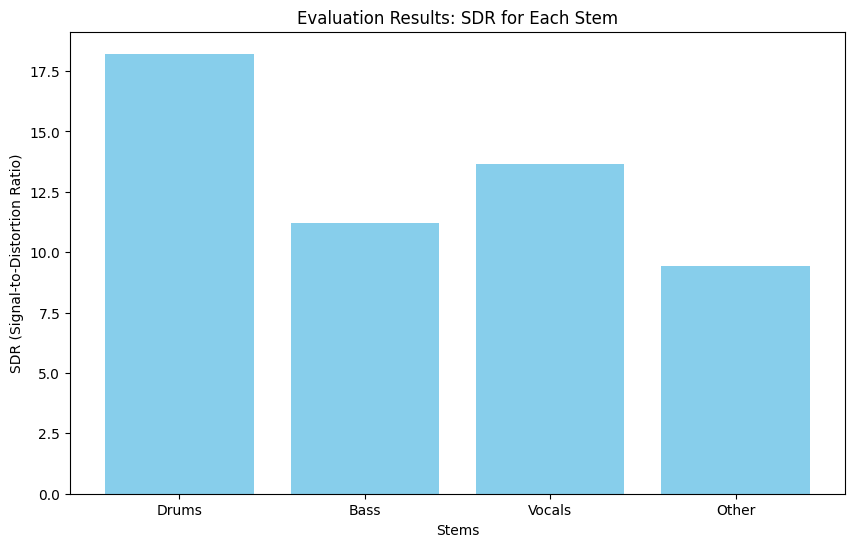

In [17]:
# Collect evaluation metrics
metrics = {
    "Drums": output_results(drums_ref, drums_pred, "Drums"),
    "Bass": output_results(bass_ref, bass_pred, "Bass"),
    "Vocals": output_results(vocals_ref, vocals_pred, "Vocals"),
    "Other": output_results(other_ref, other_pred, "Other"),
}

# Prepare data for plotting
stems = list(metrics.keys())
sdr_values = [separation.bss_eval_sources(drums_ref.cpu().numpy(), drums_pred.cpu().numpy())[0].mean(),
              separation.bss_eval_sources(bass_ref.cpu().numpy(), bass_pred.cpu().numpy())[0].mean(),
              separation.bss_eval_sources(vocals_ref.cpu().numpy(), vocals_pred.cpu().numpy())[0].mean(),
              separation.bss_eval_sources(other_ref.cpu().numpy(), other_pred.cpu().numpy())[0].mean()]

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(stems, sdr_values, color='skyblue')
plt.xlabel('Stems')
plt.ylabel('SDR (Signal-to-Distortion Ratio)')
plt.title('Evaluation Results: SDR for Each Stem')
plt.show()

## Analyze SDR / gains 

In [ ]:
# Create an array of gains from 0 to 1 for each original stem
gains = torch.tensor([1.0, 1.0, 1.0, 1.0], device=device)

In [28]:
def create_new_mixture(track_name: str, gains: torch.Tensor, dataset_dict: dict) -> torch.Tensor:
    """
    Create a new mixture for a given track name and desired gains.

    Args:
        track_name (str): The name of the track to process.
        gains (torch.Tensor): Tensor containing the gain values for each stem.
        dataset_dict (dict): Dictionary containing the dataset with track stems.

    Returns:
        torch.Tensor: The newly generated mixture waveform.
    """
    if track_name not in dataset_dict:
        raise ValueError(f"Track '{track_name}' not found in the dataset_dict.")

    # Retrieve the original stems for the given track
    original_stems = dataset_dict[track_name]

    # Normalize the gains
    gains_normalized = gains / gains.sum()
    # Ensure gains are on the same device as the stems
    device = next(iter(original_stems.values())).device
    gains_normalized = gains_normalized.to(device)

    # Exclude the "mixture" key so gains are applied only to the individual stems 
    relevant_stems = [stem for stem in original_stems.keys() if stem != "mixture"]
    adjusted_stems = {
        stem: original_stems[stem] * gains_normalized[i]
        for i, stem in enumerate(relevant_stems)
    }

    # Generate the new mixture by initializing a zero tensor on the correct device
    new_mixture = torch.zeros_like(next(iter(adjusted_stems.values())))
    for tensor in adjusted_stems.values():
        new_mixture += tensor

    return new_mixture

# Example usage:
track_name_input = "Zeno - Signs"  # Change to the desired track name
new_mix = create_new_mixture(track_name_input, gains, dataset_dict)
print(f"New mixture generated for track '{track_name_input}' with shape:", new_mix.shape)

New mixture generated for track 'Zeno - Signs' with shape: torch.Size([2, 1323000])


In [ ]:
# create a dictionary to store the SDR for each track
sdr_dict = {}

for track in tqdm.tqdm(track_names, desc="Processing tracks"):

    new_mixture = create_new_mixture(track, gains, dataset_dict)
    new_mixture = new_mixture.to(device)

    # Normalize the mixture waveform and get the reference tensor
    new_mixture, ref = normalize_waveform(new_mixture, device)

    # Separate sources
    sources_tensor = separate_sources(
        model,
        new_mixture[None],  # shape (1, channels, samples)
        segment=30,
        overlap=0.0,
        device=device
    )[0]  # shape (4, channels, samples)

    # Undo normalization
    sources_tensor = invert_normalization(sources_tensor, ref)

    # Build a dict {stem_name -> predicted_stem}
    predicted_stems = dict(zip(stem_names, list(sources_tensor)))

    # Retrieve references from dataset_dict
    stem_ref = dataset_dict[track]["drums"].to(device)
    bass_ref = dataset_dict[track]["bass"].to(device)
    vocals_ref = dataset_dict[track]["vocals"].to(device)
    other_ref = dataset_dict[track]["other"].to(device)

    # Predicted
    drums_pred = predicted_stems["drums"]
    bass_pred = predicted_stems["bass"]
    vocals_pred = predicted_stems["vocals"]
    other_pred = predicted_stems["other"]

    # calculate the energy for each reference and only perform evaluation if above the threshold

    if drums_ref.abs().sum() < energy_threshold:
        print("Drums reference energy too low - skipping SDR evaluation.")
        sdr_drums = None
    else:
        sdr_drums = separation.bss_eval_sources(
            drums_ref.cpu().numpy(), drums_pred.cpu().numpy()
        )[0].mean()

    if bass_ref.abs().sum() < energy_threshold:
        print("Bass reference energy too low - skipping SDR evaluation.")
        sdr_bass = None
    else:
        sdr_bass = separation.bss_eval_sources(
            bass_ref.cpu().numpy(), bass_pred.cpu().numpy()
        )[0].mean()

    if vocals_ref.abs().sum() < energy_threshold:
        print("Vocals reference energy too low - skipping SDR evaluation.")
        sdr_vocals = None
    else:
        sdr_vocals = separation.bss_eval_sources(
            vocals_ref.cpu().numpy(), vocals_pred.cpu().numpy()
        )[0].mean()

    if other_ref.abs().sum() < energy_threshold:
        print("Other reference energy too low - skipping SDR evaluation.")
        sdr_other = None
    else:
        sdr_other = separation.bss_eval_sources(
            other_ref.cpu().numpy(), other_pred.cpu().numpy()
        )[0].mean()

    sdr_dict[track] = {
        "drums": sdr_drums,
        "bass": sdr_bass,
        "vocals": sdr_vocals,
        "other": sdr_other
    }

Processing tracks:   0%|          | 0/50 [00:00<?, ?it/s]/var/folders/b3/9p1vx9h57c39zzmtx2ds2ffw0000gn/T/ipykernel_6246/2584229669.py:46: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr_drums = separation.bss_eval_sources(
/var/folders/b3/9p1vx9h57c39zzmtx2ds2ffw0000gn/T/ipykernel_6246/2584229669.py:54: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr_bass = separation.bss_eval_sources(
/var/folders/b3/9p1vx9h57c39zzmtx2ds2ffw0000gn/T/ipykernel_6246/2584229669.py:62: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr_vocals = separation.bss_eval_sources(
/var/folders/b3/9p1vx9h57c39zzmtx2ds2ffw0000gn/T/ipykernel_6246/2584229669.py:70: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_e

Vocals reference energy too low - skipping SDR evaluation.


Processing tracks:  20%|██        | 10/50 [01:17<05:03,  7.60s/it]

Vocals reference energy too low - skipping SDR evaluation.


Processing tracks:  22%|██▏       | 11/50 [01:24<04:40,  7.18s/it]

Vocals reference energy too low - skipping SDR evaluation.


Processing tracks:  26%|██▌       | 13/50 [01:38<04:27,  7.24s/it]

Vocals reference energy too low - skipping SDR evaluation.


Processing tracks:  28%|██▊       | 14/50 [01:44<04:09,  6.94s/it]

Vocals reference energy too low - skipping SDR evaluation.


Processing tracks:  30%|███       | 15/50 [01:50<03:55,  6.72s/it]

Vocals reference energy too low - skipping SDR evaluation.


Processing tracks:  34%|███▍      | 17/50 [02:05<03:51,  7.02s/it]

Bass reference energy too low - skipping SDR evaluation.


Processing tracks:  40%|████      | 20/50 [02:27<03:43,  7.44s/it]

Vocals reference energy too low - skipping SDR evaluation.


Processing tracks:  42%|████▏     | 21/50 [02:33<03:25,  7.08s/it]

Bass reference energy too low - skipping SDR evaluation.


Processing tracks:  62%|██████▏   | 31/50 [03:52<02:32,  8.02s/it]

Bass reference energy too low - skipping SDR evaluation.


Processing tracks:  74%|███████▍  | 37/50 [04:39<01:43,  7.99s/it]

Bass reference energy too low - skipping SDR evaluation.


Processing tracks:  76%|███████▌  | 38/50 [04:45<01:29,  7.47s/it]

Bass reference energy too low - skipping SDR evaluation.


Processing tracks:  84%|████████▍ | 42/50 [05:16<01:01,  7.73s/it]

Vocals reference energy too low - skipping SDR evaluation.


Processing tracks:  86%|████████▌ | 43/50 [05:22<00:50,  7.28s/it]

Vocals reference energy too low - skipping SDR evaluation.


Processing tracks:  92%|█████████▏| 46/50 [05:44<00:30,  7.52s/it]

Bass reference energy too low - skipping SDR evaluation.


Processing tracks: 100%|██████████| 50/50 [06:15<00:00,  7.51s/it]


In [36]:
sdr_dict

{'AM Contra - Heart Peripheral': {'drums': np.float64(-34.900943955856796),
  'bass': np.float64(-10.256681605000207),
  'vocals': np.float64(16.513330246623422),
  'other': np.float64(19.14713069538324)},
 'Al James - Schoolboy Facination': {'drums': np.float64(-35.781597224283374),
  'bass': np.float64(10.790073825891897),
  'vocals': np.float64(11.234272757835896),
  'other': np.float64(7.680852177998441)},
 "Angels In Amplifiers - I'm Alright": {'drums': np.float64(-32.318065072400614),
  'bass': np.float64(9.913367236565033),
  'vocals': np.float64(12.350509244990054),
  'other': np.float64(13.248464334399053)},
 'Arise - Run Run Run': {'drums': np.float64(-29.049900564650663),
  'bass': np.float64(12.17438528992325),
  'vocals': np.float64(12.124005104810884),
  'other': np.float64(15.801729336725314)},
 'BKS - Bulldozer': {'drums': np.float64(-31.01033174119188),
  'bass': np.float64(14.235384502439647),
  'vocals': np.float64(17.851051124725668),
  'other': np.float64(11.979840